In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
from Core.Utils.Swin_Transformer_Classification import Swintransformer
import sys
sys.path.append('../')
from Core.Dataset.Dataloader import *
from torch.utils.data import Subset
from Core.Utils.Utility import Balanced_sampler
from monai.transforms import (EnsureChannelFirst,
                              Resize,
                              NormalizeIntensity,
                              ToTensor,
                              Resize,
                            NormalizeIntensity,
                            ResizeWithPadOrCrop,
                            SpatialPad,
                            CenterSpatialCrop)

import roc_utils as ru
from tqdm import tqdm
from roc_utils import *



class Evaluation:
    def __init__(self,tr_file,val_file,val_four_rate,save_path) -> None:
        self.tr_df = pd.read_csv(tr_file)
        self.val_df = pd.read_csv(val_file)
        #self.val_metric_df = pd.read_csv(val_four_rate)
        self.save_path = save_path

    def plot_loss(self):
        tr_loss = self.tr_df['loss'].values
        val_loss = self.val_df['loss'].values
        val_accuracy= self.val_df['accuracy'].values
        plt.plot(tr_loss,label='train')
        plt.plot(val_loss,label='val')
        plt.plot(val_accuracy,label='accuracy')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.savefig(self.save_path)
        plt.legend()
        plt.show()

    def plot_auc(self):
        tr_auc = self.tr_df['roc_auc'].values
        val_auc = self.val_df['roc_auc'].values
        plt.plot(tr_auc,label='train')
        plt.plot(val_auc,label='val')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('AUC Values')
        plt.savefig(self.save_path)

    def plot_recall(self):
        val_recall = self.val_df['recall'].values
        val_precision = self.val_df['precision'].values
        plt.plot(val_recall,label='recall')
        plt.plot(val_precision,label='precision')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('recall-precision')
        plt.show()
    
    @staticmethod
    def calculate_average(metric_lst,metric='accuracy'):
        average_metric = []
        for metric_file in metric_lst:
            df = pd.read_csv(metric_file)
            average_metric.append(df[metric].values[-1])
        return average_metric
    
    

def load_model(model,weight_path):
    model_weight = torch.load(weight_path)['model']
    model.load_state_dict(model_weight)
    return model    

def load_data(data_path,label_path):
    
    transform_param = {"transform_methods":[
                            EnsureChannelFirst(),
                            # Data augmentation
                            #RandZoom(prob = 0.5, min_zoom=1.0, max_zoom=1.2),
                            #RandRotate(range_z = 0.35, prob = 0.5),
                            #RandFlip(prob = 0.5),
                            Resize((256,256,64)),
                            SpatialPad((256,256,64)),
                            CenterSpatialCrop((256,256,64)),
                            NormalizeIntensity(),

                            # To tensor
                            ToTensor()
                            ]}



    Data = DataFiles(data_path,label_path,'HGP_Type')
    images_lst = sorted(Data.get_images())
    labels_lst = Data.get_labels()
    val_dataset =  Image_Dataset(image_files=images_lst,labels=labels_lst,transform_methods=transform_param['transform_methods'],data_aug=True,label_name=None,reader='ITKReader',
                                padding_size=None)


    val_dataloader = Data_Loader(dataset=val_dataset,batch_size=2,num_workers=0).build_vali_loader() 
    return val_dataloader


def Validation_loop(model,dataloader,criterion=torch.nn.CrossEntropyLoss()):
    """
    args:
        model: model to be trained
        dataloader: dataloader
        device: device to train on
        criterion: loss function
        visual_input: visualize input
    """
    #prepare data for training
    vali_bar = tqdm(dataloader)
    average_loss = 0

    #set metrics record
    y_pred = []
    y_true = []
    print("##################")
    print("##################")
    #model = model.to(device)
    #predict


    for i,(im,label,_) in enumerate(vali_bar):       
        #rotate and flip
        im = torch.rot90(im,k=3,dims=(2,3))
        im = torch.flip(im,[3])
        #permute to [B,C,D,H,W]
        im = im.permute(0,1,4,2,3)

        #im,label = im.to(cfg.SYSTEM.DEVICE),label.to(cfg.SYSTEM.DEVICE)
        #print('validation',im.shape,label)

        with torch.no_grad():
            output = (model(im))

            loss = criterion(output,label)
            average_loss += loss.item()

            #softmax probability
            output = torch.nn.functional.softmax(output,dim=1)
            #print('this is output',output)

    

        #softmax probability
        y_pred.append(output.cpu())
        y_true.extend(label.cpu().numpy().tolist())


        #print("this is y_pred",output,'and this is y_true',label)
        #print("this is step loss",loss)
        
        #set description for tqdm


        vali_bar.set_description(f"label{label},loss:{average_loss},out_put_prob:{output}")

        #metrics
    

    
    average_loss = average_loss/len(vali_bar)
    print('this is average loss',average_loss)
    return average_loss,y_pred,y_true
      

C:\Users\098986\AppData\Local\Temp\ipykernel_28660\1072663450.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
os.listdir('../Experiments/exp1/No_resize/02/')

['train_Four_rate.csv',
 'train_metrics.csv',
 'vali_four rates.csv',
 'vali_metrics.csv',
 'vali_pred_.txt',
 'Visual']

In [13]:
pd.read_csv('../../Output/SwingTransformer/Cluster/SWIN-07073-all-tumor/02/')

PermissionError: [Errno 13] Permission denied: '../../Output/SwingTransformer/Cluster/SWIN-07073-all-tumor/02/'

In [9]:
pd.read_csv(path +'/vali_metrics.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../../Output/SwingTransformer/Cluster/SWIN-07073-all-tumor/02/vali_metrics.csv'

In [28]:
os.listdir('../../Output/SwingTransformer/Cluster/SWIN-07073-all-tumor/02/')

['output.png',
 'prediction_result.png',
 'train_Four_rate.csv',
 'train_metrics.csv',
 'vali_four rates.csv',
 'vali_metrics .csv',
 'vali_pred_.txt']

In [27]:
import os
pd.read_csv('../../Output/SwingTransformer/Cluster/SWIN-07073-all-tumor/02/')

PermissionError: [Errno 13] Permission denied: '../../Output/SwingTransformer/Cluster/SWIN-07073-all-tumor/02/'

In [9]:
import pandas as pd
import numpy as np
import scipy.stats
import os
results_path = 'c:/Users/098986/Intership_CILM/Output/Resnet10/Cluster/Per_tumor_07071_no_extend/'
folds = ['0','1','2']
roc = []
accuracy = []
f1_score = []
for fold in folds:
    path = os.path.join(results_path, fold, 'vali_metrics.csv')
    result = pd.read_csv(path)
    # Get the row with the largest ROC value
    max_roc_row = result.iloc[-1,:]
    
    # Append the largest ROC and corresponding accuracy and F1 score to the lists
    roc.append(max_roc_row['roc_auc'])
    accuracy.append(max_roc_row['accuracy'])
    f1_score.append(max_roc_row['f1_score'])

# Assuming you want to see the results
print("ROC:", roc)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)


roc = np.array(roc)
accuracy = np.array(accuracy)
f1_score = np.array(f1_score)

# Function to calculate the confidence interval
def calculate_confidence_interval(data):
    mean = np.mean(data)
    sem = scipy.stats.sem(data)  # Standard error of the mean
    z_score = 1.96  # Z-score for 95% confidence interval
    margin_of_error = z_score * sem
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return mean, lower_bound, upper_bound

# Calculate confidence intervals
roc_mean, roc_lower, roc_upper = calculate_confidence_interval(roc)
accuracy_mean, accuracy_lower, accuracy_upper = calculate_confidence_interval(accuracy)
f1_score_mean, f1_score_lower, f1_score_upper = calculate_confidence_interval(f1_score)

# Print results
print(f"ROC: {roc_mean:.2f} [{roc_lower:.2f}, {roc_upper:.2f}]")
print(f"Accuracy: {accuracy_mean:.2f} [{accuracy_lower:.2f}, {accuracy_upper:.2f}]")
print(f"F1 Score: {f1_score_mean:.2f} [{f1_score_lower:.2f}, {f1_score_upper:.2f}]")

ROC: [0.526355140186916, 0.4717757009345794, 0.5787373004354136]
Accuracy: [0.8106060606060606, 0.7651515151515151, 0.7878787878787878]
F1 Score: [0.0, 0.0, 0.125]
ROC: 0.53 [0.47, 0.59]
Accuracy: 0.79 [0.76, 0.81]
F1 Score: 0.04 [-0.04, 0.12]


: 

In [3]:
max_roc_row

2              201.000000
7               37.000000
1               10.000000
10               1.000000
32               2.000000
10.1             1.000000
32.1             2.000000
7.1             37.000000
1.1             10.000000
0.34             0.760000
0.566433566      0.571096
0.377358491      0.142857
0.771610168      0.625923
Name: 198, dtype: float64

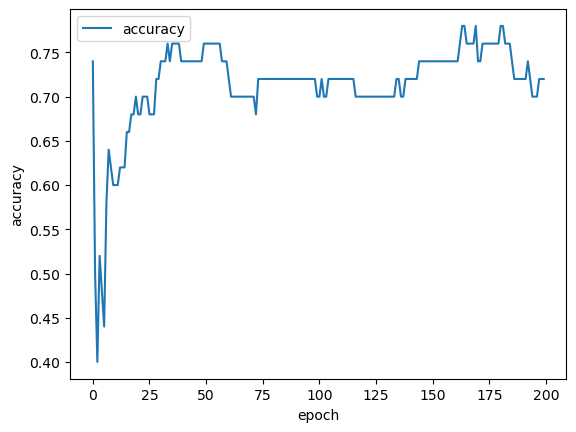

In [7]:
val_metrics = pd.read_csv('../../Output/Resnet10/Cluster/Exp_1/04/vali_metrics.csv')
val_f1_score = val_metrics['accuracy'].values
plt.plot(val_f1_score,label='accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [19]:
val_four_rates

,epoch,class_id,f1,auc,accuracy,precision,recall
1,1,1,0.357143,0.573427,0.64,0.294118,0.454545
3,2,1,0.300000,0.559441,0.72,0.333333,0.272727
5,3,1,0.300000,0.559441,0.72,0.333333,0.272727
7,4,1,0.400000,0.611888,0.70,0.357143,0.454545
9,5,1,0.416667,0.624709,0.72,0.384615,0.454545
...,...,...,...,...,...,...,...
391,196,1,0.214286,0.456876,0.56,0.176471,0.272727
393,197,1,0.214286,0.456876,0.56,0.176471,0.272727
395,198,1,0.222222,0.469697,0.58,0.187500,0.272727
397,199,1,0.222222,0.469697,0.58,0.187500,0.272727


In [15]:
val_four_rates

,epoch,class_id,f1,auc,accuracy,precision,recall
0,1,0,0.750000,0.573427,0.64,0.818182,0.692308
1,1,1,0.357143,0.573427,0.64,0.294118,0.454545
2,2,0,0.825000,0.559441,0.72,0.804878,0.846154
3,2,1,0.300000,0.559441,0.72,0.333333,0.272727
4,3,0,0.825000,0.559441,0.72,0.804878,0.846154
...,...,...,...,...,...,...,...
395,198,1,0.222222,0.469697,0.58,0.187500,0.272727
396,199,0,0.712329,0.469697,0.58,0.764706,0.666667
397,199,1,0.222222,0.469697,0.58,0.187500,0.272727
398,200,0,0.712329,0.469697,0.58,0.764706,0.666667


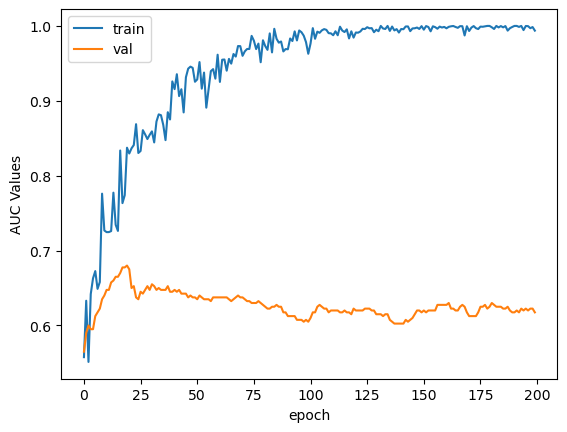

In [20]:

tr_file = '../Experiments/exp1/padding_crop/02/train_metrics.csv'
val_file = '../Experiments/exp1/padding_crop/02/vali_metrics.csv'
eva_1 = Evaluation(tr_file,val_file,None,'../Experiments/exp1/padding_crop/02/auc.png')
#eva_1.plot_recall()
eva_1.plot_auc()

In [7]:
#load model
model = Swintransformer(img_size=(64,256,256),in_channels=1,out_channels=1)
weight_path = '../../Output/SwingTransformer/Cluster/Test_03/04/best_metric_21.pth'
model = load_model(model,weight_path)

#load data
data_path = '../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073_windowed/'
label_path = '../../Data/Mixed_HGP/True_Label/val_cv_3.csv'

val_dataloader = load_data(data_path,label_path)



c:\Users\098986\AppData\Local\anaconda3\envs\CILM\lib\site-packages\monai\transforms\io\array.py:205: UserWarning: required package for reader ITKReader is not installed, or the version doesn't match requirement.
  warnings.warn(


AttributeError: '_IncompatibleKeys' object has no attribute 'parameters'

In [ ]:
av_loss,y_pred,y_true = Validation_loop(model,val_dataloader)

In [271]:
y_pred = torch.cat(y_pred,dim=0)
y_pred = y_pred[:,1].detach().numpy()
y_true = np.array(y_true)

TypeError: cat() received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [15]:
#load last time
y_pred = np.load('../../Output/SwingTransformer/Cluster/Test_03/04/y_pred_21.npy')
y_true = np.load('../../Output/SwingTransformer/Cluster/Test_03/04/y_true_21.npy')

In [272]:
y_pred= y_pred.reshape(-1)

In [273]:
ru.compute_roc_bootstrap(y_pred,y_true,pos_label=1)

struct(**{'fpr': array([0.  , 0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
       0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
       0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
       0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97,
       0.98, 0.99, 1.  ]), 'tpr': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.   

struct(**{'fpr': array([0.  , 0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
       0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
       0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
       0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97,
       0.98, 0.99, 1.  ]), 'tpr': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.   

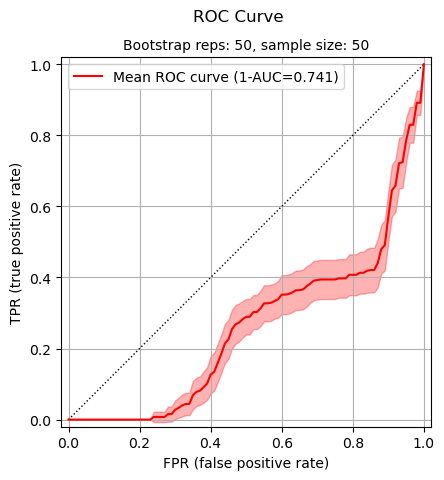

In [277]:
roc_1 = compute_roc(y_pred,y_true,pos_label=1)
ru.plot_roc_bootstrap(y_pred,y_true,
pos_label=1,n_bootstrap=50,title='ROC Curve',show_ti=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import roc_utils as ru

# Construct a binary classification problem
x, y = ru.demo_sample_data(n1=300, mu1=0.0, std1=0.5,
                           n2=300, mu2=1.0, std2=0.7)

# Compute the ROC curve...
pos_label = True
roc = ru.compute_roc(X=x, y=y, pos_label=pos_label)

# ...and visualize it
ru.plot_roc(roc, label="Sample data", color="red")
plt.show()

# To perform a ROC analysis using bootstrapping
n_samples = 20
ru.plot_roc_bootstrap(X=x, y=y, pos_label=pos_label,
                      n_bootstrap=n_samples,
                      title="Bootstrap demo");
plt.show()

In [ ]:
def Validation_loop(model,dataloader,criterion):
    """
    args:
        model: model to be trained
        dataloader: dataloader
        device: device to train on
        criterion: loss function
        visual_input: visualize input
    """
    #prepare data for training
    vali_bar = tqdm(dataloader)
    average_loss = 0

    #set metrics record
    y_pred = []
    y_true = []
    print("##################")
    print("##################")
    #model = model.to(device)
    #predict


    for i,(im,label,_) in enumerate(vali_bar):       
        #rotate and flip
        im = torch.rot90(im,k=3,dims=(2,3))
        im = torch.flip(im,[3])
        #permute to [B,C,D,H,W]
        im = im.permute(0,1,4,2,3)

        #im,label = im.to(cfg.SYSTEM.DEVICE),label.to(cfg.SYSTEM.DEVICE)
        #print('validation',im.shape,label)

        with torch.no_grad():
            output = (model(im))

            loss = criterion(output,label)
            average_loss += loss.item()

            #softmax probability
            output = torch.nn.functional.softmax(output,dim=1)
            #print('this is output',output)

    

        #softmax probability
        y_pred.append(output.cpu())
        y_true.extend(label.cpu().numpy().tolist())


        #print("this is y_pred",output,'and this is y_true',label)
        #print("this is step loss",loss)
        
        #set description for tqdm


        vali_bar.set_description(f"label{label},loss:{average_loss},out_put_prob:{output}")

        #metrics
    

    
    average_loss = average_loss/len(vali_bar)
    print('this is average loss',average_loss)
    return average_loss,y_pred,y_true
      

In [266]:
import os
import sys
sys.path.append('../')
from Core.Utils import Swin_Transformer_Classification
from Core.Dataset.Dataloader import Image_Dataset,Data_Loader,DataFiles
import torch

model = Swin_Transformer_Classification.Swintransformer(img_size=(64,256,256),in_channels=1,out_channels=1)

model.load_state_dict(torch.load('../../Output/SwingTransformer/Cluster/Test_03/01/best_metric_41.pth')['model'])

<All keys matched successfully>

In [267]:
from monai.transforms import (EnsureChannelFirst,
                              Resize,
                              SpatialPad,
                              CenterSpatialCrop,
                              NormalizeIntensity,
                              ToTensor) 
from Core.model import Validation
from tqdm import tqdm
transform_param_val = {"transform_methods":[EnsureChannelFirst(),
                                                    Resize((256,256,-1)),
                                                    SpatialPad((256,256,64)),
                                                    CenterSpatialCrop((256,256,64)),
                                                    NormalizeIntensity(),
                                                    ToTensor()]}
                
data_path = '../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073_windowed/'
label_path = '../../Data/Mixed_HGP/True_Label/val_cv_0.csv'
Data = DataFiles(data_path,label_path,'HGP_Type')
images_lst = sorted(Data.get_images())
labels_lst = Data.get_labels()

val_dataset =  Image_Dataset(image_files=images_lst,labels=labels_lst,transform_methods=transform_param_val['transform_methods'],data_aug=True,label_name=None,reader='ITKReader',
                            padding_size=None)


val_dataloader = Data_Loader(dataset=val_dataset,batch_size=2,num_workers=0).build_vali_loader() 
loss = torch.nn.CrossEntropyLoss()

c:\Users\098986\AppData\Local\anaconda3\envs\CILM\lib\site-packages\monai\transforms\io\array.py:205: UserWarning: required package for reader ITKReader is not installed, or the version doesn't match requirement.
  warnings.warn(


In [ ]:
loss,y_pred,y_true = Validation_loop(model,val_dataloader,loss)

In [269]:
np.save('../../Output/SwingTransformer/Cluster/Test_03/01/y_pred_41.npy',y_pred)
np.save('../../Output/SwingTransformer/Cluster/Test_03/01/y_true_41.npy',y_true)

# check prediction


In [58]:
import pandas as pd
import numpy as np


In [59]:
import pandas as pd

# 假设val_prediction是你的原始DataFrame

# 初始化一个空列表来存储新的行
def clean_df(val_prediction,epoch_range=(1,50)):
    new_rows = []

    # 按每两行进行遍历处理
    for i in range(0, len(val_prediction), 2):
        # 移除非数字字符并合并当前行和下一行的数据
        row1 = val_prediction.iloc[i, 0].replace('[', '').replace(']', '').split()
        row2 = val_prediction.iloc[i + 1, 0].replace('[', '').replace(']', '').split()
        combined_row = list(map(int, row1 + row2))

        # 添加到新行的列表中
        new_rows.append(combined_row)

    # 创建一个新的DataFrame
    new_df = pd.DataFrame(new_rows)

    #chosse rows within ranges
    new_df = new_df.iloc[epoch_range[0]:epoch_range[1],:]

    
    return new_df


In [186]:
fold_non_overfit_range = ((4,56),(11,51),(4,53),(22,61))

In [232]:
val_fold_5 = pd.read_csv('../../Data/Mixed_HGP/True_Label/val_cv_4.csv')
val_fold_5_dict = {i:None for i in val_fold_5.Experiment}
epoch_range = (22,61)
val_prediction = pd.read_table('../../Output/SwingTransformer/Cluster/Test_03/05/vali_pred_.txt',header=None)
val_prediction = clean_df(val_prediction,epoch_range=epoch_range)
val_fold_5_pred = val_prediction.apply(lambda x: x.value_counts().index[0],axis=1)

In [233]:
# mode() 返回的是一个DataFrame，我们取第0行，因为可能存在多个众数，我们只取第一个
final_predictions = val_prediction.mode().iloc[0]

# 将最终预测转换为列表
final_predictions_list = final_predictions.tolist()


In [234]:

# 输出最终预测列表
for keys,value in zip(val_fold_5_dict.keys(),final_predictions_list):
    val_fold_5_dict[keys] = value


val_fold_5_true = val_fold_5['HGP_Type'].values

for keys,index in zip(val_fold_5_dict.keys(),val_fold_5_true):
    if val_fold_5_dict[keys] == val_fold_5_true[index]:
        val_fold_5_dict[keys] = 1
    else:
        val_fold_5_dict[keys] = 0

In [235]:
val_fold_5_dict

{'CT_10785': 1,
 'CT_11111': 1,
 'CT_11136': 0,
 'CT_11447': 1,
 'CT_12190': 0,
 'CT_13419': 1,
 'CT_13999': 1,
 'CT_14299': 1,
 'CT_15820': 1,
 'CT_16555': 0,
 'CT_17684': 0,
 'CT_18041': 1,
 'CT_19439': 1,
 'CT_19752': 1,
 'CT_20342': 0,
 'CT_20378': 0,
 'CT_20646': 1,
 'CT_20985': 0,
 'CT_21114': 1,
 'CT_21399': 0,
 'CT_21919': 0,
 'CT_23726': 0,
 'CT_23857': 0,
 'CT_25615': 1,
 'CT_27354': 0,
 'CT_29793': 1,
 'CT_29799': 0,
 'CT_29977': 1,
 'CT_31460': 0,
 'CT_31851': 1,
 'CT_32378': 0,
 'CT_32505': 0,
 'CT_32653': 0,
 'CT_32915': 1,
 'CT_33488': 0,
 'CT_33791': 1,
 'CT_33891': 1,
 'CT_39229': 1,
 'CT_40447': 1,
 'CT_50410': 1,
 'CT_50926': 1,
 'CT_54293': 1,
 'CT_55046': 1,
 'CT_79221': 1,
 'CT_80259': 1,
 'CT_81233': 1,
 'CT_82801': 0,
 'CT_88827': 0,
 'CT_94912': 1}

In [236]:
merged_4_folds = {**val_fold_2_dict,**val_fold_3_dict,**val_fold_4_dict,**val_fold_5_dict}
four_fold_pre = pd.DataFrame.from_dict(merged_4_folds,orient='index',columns=['pred'])
four_fold_pre.to_csv('../../Output/SwingTransformer/Cluster/Test_03/four_fold_pre.csv')

In [237]:
all_data = pd.read_csv('../../Data/Mixed_HGP/True_Label/scans_used_all_info_with_tumor.csv')
all_Data_dhgp = all_data[all_data['HGP_Type'] == 1]
all_Data_non_dhgp = all_data[all_data['HGP_Type'] == 0]


In [238]:

all_correct_Data = four_fold_pre[four_fold_pre['pred'] == 1]
all_incorrect_Data = four_fold_pre[four_fold_pre['pred'] == 0]

all_correct_dhgp_data = all_Data_dhgp[all_Data_dhgp['Experiment'].isin(all_correct_Data.index)]
all_incorrect_dhgp_data = all_Data_dhgp[all_Data_dhgp['Experiment'].isin(all_incorrect_Data.index)]

all_correct_non_dhgp_data = all_Data_non_dhgp[all_Data_non_dhgp['Experiment'].isin(all_correct_Data.index)]
all_incorrect_non_dhgp_data = all_Data_non_dhgp[all_Data_non_dhgp['Experiment'].isin(all_incorrect_Data.index)]

In [248]:
all_incorrect_non_dhgp_data

,PID,Subject,Experiment,Scan,pHGP,dHGP,rHGP,HGP_Type,Series_description,acquisition_time,...,seriesdate_y,gender,age,model_name,patient_position,manufacturer,slice_thickness,convolution_kernel,prediction,tumor_size
0,3932332,CRLM_137,CT_10033,4,0.000000,30.000000,70.000000,0,Lever meta's 2.0 B31f,84259.93629,...,20060906.0,F,073Y,Sensation 16,HFS,SIEMENS,"""2""",B31f,NaN,9814
6,328205,CRLM_008,CT_10871,3,0.000000,1.666667,98.333333,0,Abdomen 2.0 B31f,144404.12050,...,20100222.0,M,069Y,Sensation 10,FFS,SIEMENS,"""2""",B31s,NaN,3048
7,741673,CRLM_029,CT_10929,6,0.000000,5.000000,95.000000,0,ONCO ThAbd 1.5 B70f,112745.11970,...,20141028.0,M,061Y,Sensation 64,HFS,SIEMENS,"""1.5""",B70f,NaN,18782
12,6684059,CRLM_226,CT_11136,797,60.000000,20.000000,20.000000,0,NaN,85413.00000,...,NaN,M,066Y,Mx8000 IDT 16,FFS,Philips,"""2.0""",B,NaN,56132
15,6927879,CRLM_242,CT_11655,2,8.500000,25.500000,66.000000,0,Thorax 3mm,145655.00000,...,NaN,M,031Y,Brilliance 64,FFS,Philips,"""3.00""",B,NaN,3150
20,4560823,CRLM_157,CT_12017,2,0.000000,20.000000,80.000000,0,Th. tumor 5.0 B31f,90557.63021,...,20040419.0,M,063Y,Sensation 16,HFS,SIEMENS,"""5""",B31f,NaN,4812
21,4344349,CRLM_150,CT_12190,3,0.000000,76.666667,23.333333,0,Veneus Sft Tissue 4.0 CE,170146.85000,...,20170117.0,M,077Y,Aquilion,FFS,TOSHIBA,"""4.0""",FC08,NaN,746
22,4033021,CRLM_141,CT_12276,9,0.000000,95.000000,5.000000,0,NaN,144225.95000,...,NaN,M,083Y,Aquilion,HFS,TOSHIBA,"""3.0""",FC10,NaN,3954
25,275031,CRLM_004,CT_12906,3,0.000000,99.000000,1.000000,0,Abd 5.0 mm,113333.00000,...,NaN,M,070Y,Brilliance 64,FFS,Philips,"""5.00""",B,NaN,678
27,637720,CRLM_023,CT_12957,8,22.500000,1.250000,76.250000,0,Lever 60 sec 2.0 B31f,134222.01100,...,20090921.0,F,073Y,Sensation 10,FFS,SIEMENS,"""2""",B31f,NaN,25078


In [249]:
all_correct_dhgp_data_tumor_size = all_correct_dhgp_data['tumor_size'].values
all_incorrect_dhgp_data_tumor_size = all_incorrect_dhgp_data['tumor_size'].values

all_correct_non_dhgp_data_tumor_size = all_correct_non_dhgp_data['tumor_size'].values
all_incorrect_non_dhgp_data_tumor_size = all_incorrect_non_dhgp_data['tumor_size'].values

all_folds_data_tumor_size = all_data[all_data['Experiment'].isin(four_fold_pre.index)]['tumor_size'].values

KeyError: 49

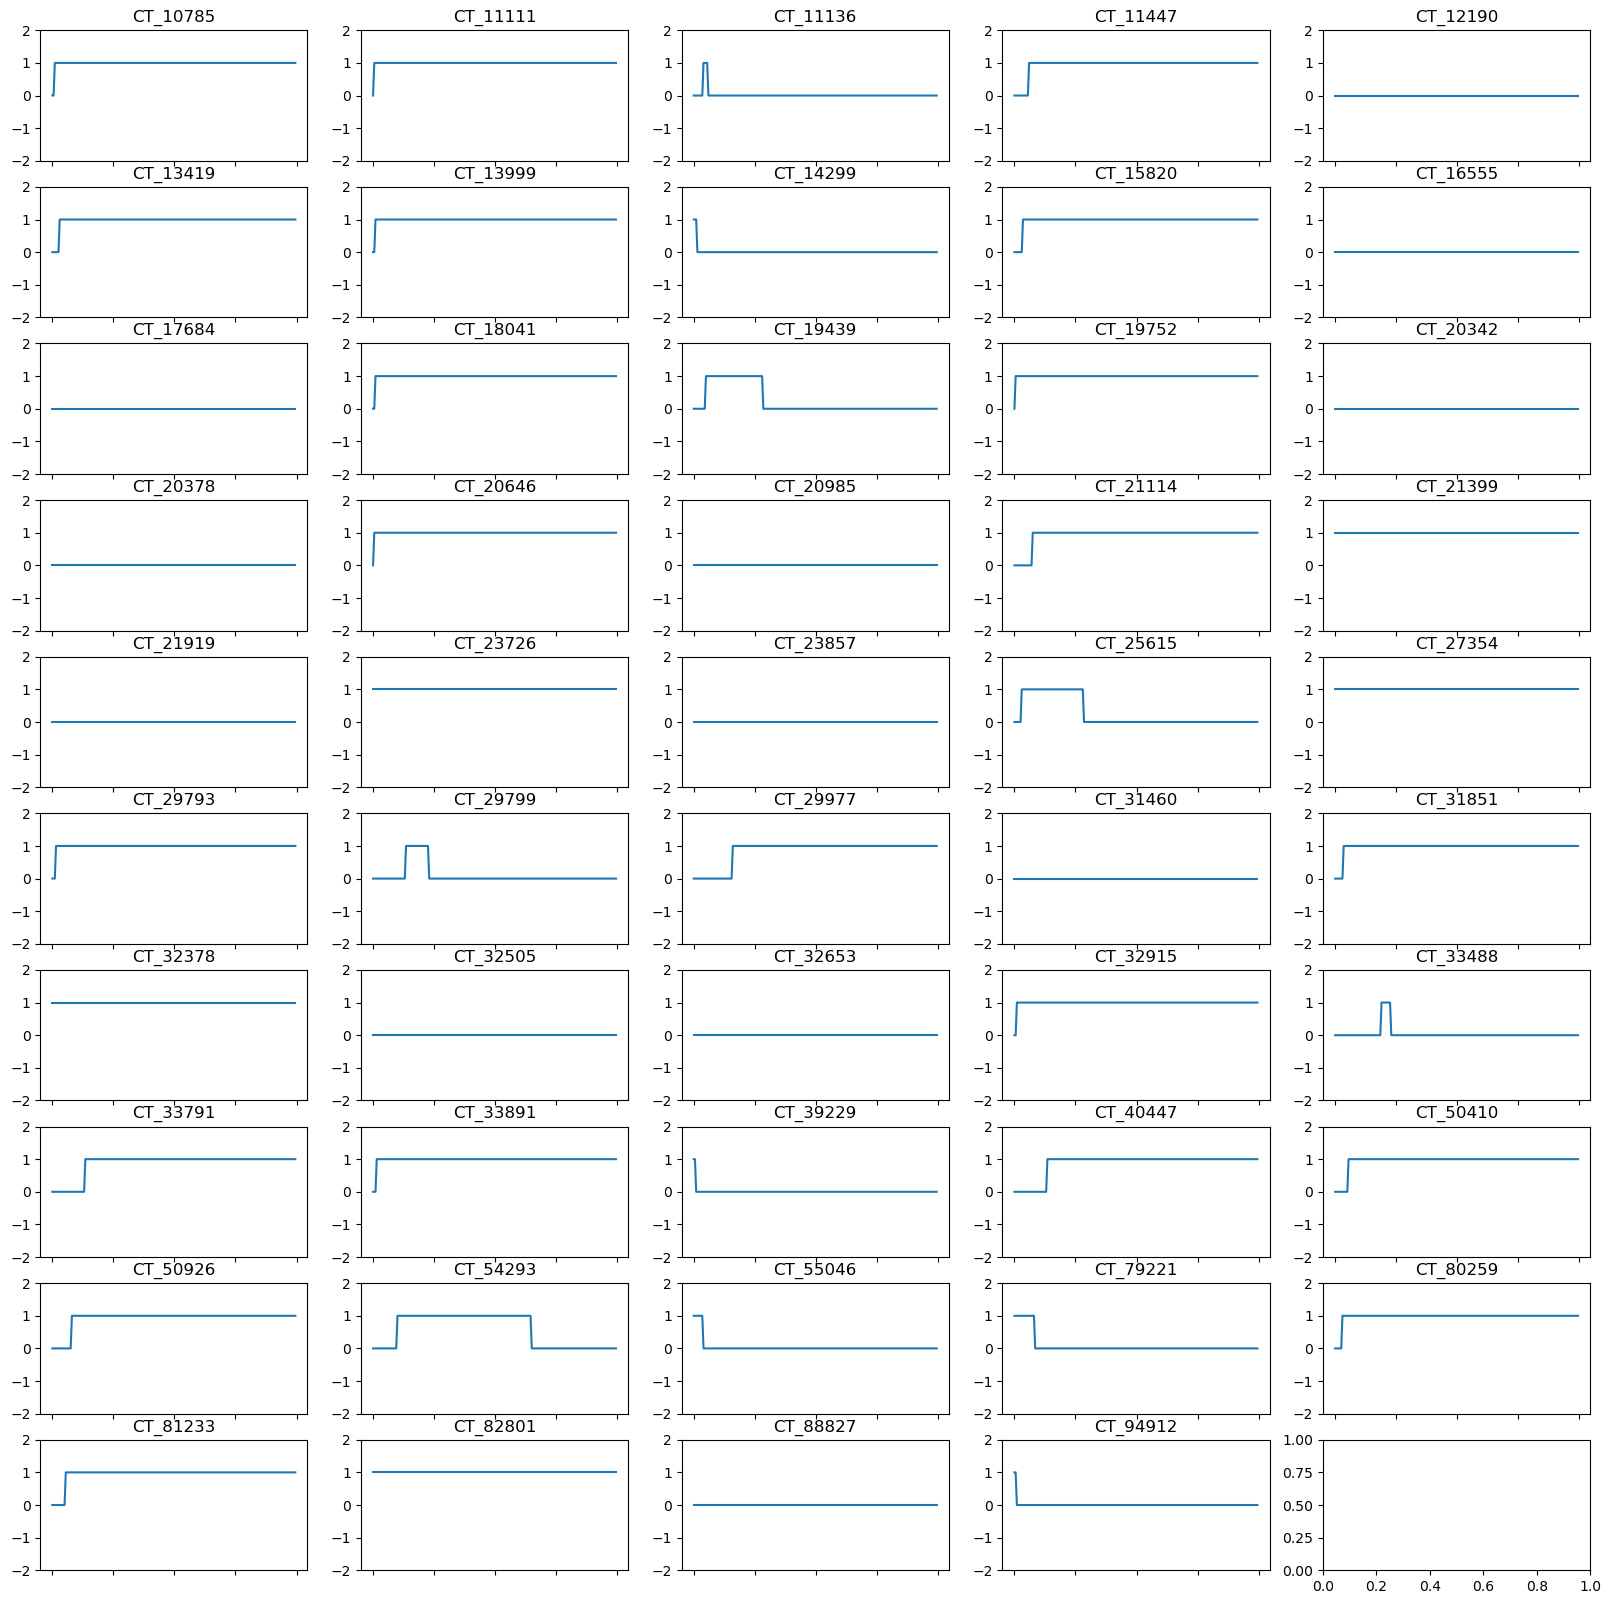

In [277]:
#subplots 10 x 5
#set y axis to 0-1
import matplotlib.pyplot as plt

# 假设 pre_dict 是您的数据字典
# pre_dict = {0: data0, 1: data1, ..., 49: data49}

fig, ax = plt.subplots(10, 5, figsize=(20, 20))
sample_name_lst = true_label_df.Experiment.values.tolist()
for i in range(10):
    for j in range(5):
        # 绘制每个子图
        ax[i, j].plot(pre_dict[i * 5 + j])
        ax[i, j].set_title(f'{sample_name_lst[i * 5 + j]}')
        
        # 设置 y 轴的范围为 0 到 1
        ax[i, j].set_ylim([-2, 2])
        ax[i, j].set_xticklabels([])
plt.tight_layout()  # 调整子图的布局
plt.show()    

In [294]:
def label_prediction(dict,exp_name,correct=1):
    """
    input pre_dict, and regarding experiment name
    """
    dict[exp_name] = correct
    return dict

prediction_correct = label_prediction(prediction_correct,'CT_94912',correct=0)

In [296]:
#save the dict
import pickle
with open('../../Output/SwingTransformer/Cluster/Test_03/bad_prediction.pkl', 'wb') as f:
    pickle.dump(prediction_correct, f)

In [297]:
#extract 0 values from dict
import numpy as np

prediction_correct = {k:v for k,v in prediction_correct.items() if v == 0}
prediction_correct_2folds = list(prediction_correct.keys())

In [212]:
data_info.tumor_size.values.tolist()
#quantile of tumor size
np.quantile(data_info.tumor_size.values.tolist(),0.25)

3048.0

In [316]:
#get exp in list
data_info = pd.read_csv('../../Data/Mixed_HGP/True_Label/scans_used_all_info_with_tumor.csv')
bad_pre_size = data_info.loc[data_info['Experiment'].isin(prediction_correct_2folds)]
all_size = data_info


In [327]:
sum(bad_pre_size.tumor_size.values < 7000)

38

In [348]:
np.quantile(data_info.dHGP.values,0.25)
#calculate quantile but except dHGP=100
np.quantile(data_info[data_info['dHGP'] != 100].dHGP.values,0.85)

81.000000002

In [361]:
np.quantile(data_info.tumor_size.values,0.5)

7528.0

In [376]:
bad_pre_size_data = bad_pre_size.tumor_size.values
all_size_data = all_size.tumor_size.values


[7, 3, 4, 2, 3, 0, 0, 2, 0, 1] [5, 4, 1, 4, 1, 1, 3, 1, 0, 0]


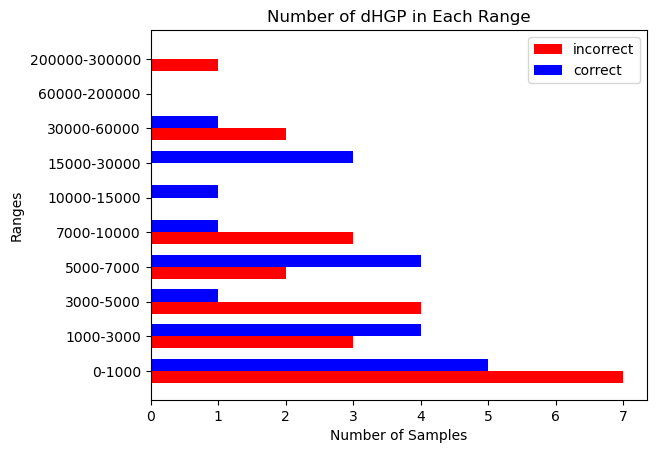

In [277]:

import numpy as np
import matplotlib.pyplot as plt


ranges = [(0,1000),(1000, 3000), (3000, 5000), (5000,7000),(7000, 10000),(10000,15000), (15000, 30000), (30000, 60000),(60000,200000),(200000,300000)]

def plot_sample_distribution(data1, data2, ranges, label1='Data 1', label2='Data 2'):
    """
    绘制两组数据在给定区间内的样本分布条形图。
    
    :param data1: 第一组数据，NumPy数组或列表。
    :param data2: 第二组数据，NumPy数组或列表。
    :param ranges: 定义的区间列表，形如 [(start1, end1), (start2, end2), ...]。
    :param label1: 第一组数据的标签。
    :param label2: 第二组数据的标签。
    """
    # 计算每个区间的样本数
    def count_in_ranges(data, ranges):
        counts = []
        for r in ranges:
            count = ((data >= r[0]) & (data < r[1])).sum()
            counts.append(count)
        return counts

    # 计算两组数据的区间样本数
    data1_counts = count_in_ranges(data1, ranges)
    data2_counts = count_in_ranges(data2, ranges)
    print(data1_counts,data2_counts)

    # 创建条形图
    y_positions = np.arange(len(ranges))
    bar_width = 0.35

    plt.barh(y_positions - bar_width/2, data1_counts, bar_width, label=label1, color='red')
    plt.barh(y_positions + bar_width/2, data2_counts, bar_width, label=label2, color='blue')

    # 设置 y 轴的刻度标签
    plt.yticks(y_positions, [f"{r[0]}-{r[1]}" for r in ranges])

    plt.xlabel('Number of Samples')
    plt.ylabel('Ranges')
    plt.title('Number of dHGP in Each Range')
    plt.legend()

    plt.show()

# 使用示例
plot_sample_distribution(all_incorrect_dhgp_data_tumor_size,all_correct_dhgp_data_tumor_size, ranges, label1='incorrect', label2='correct')


In [279]:
all_correct_non_dhgp_data

,PID,Subject,Experiment,Scan,pHGP,dHGP,rHGP,HGP_Type,Series_description,acquisition_time,...,seriesdate_y,gender,age,model_name,patient_position,manufacturer,slice_thickness,convolution_kernel,prediction,tumor_size
1,4327749,CRLM_147,CT_10043,2,32.500000,22.500000,45.000000,0,ABDOMEN 2/2,141238.00000,...,NaN,M,NaN,Mx8000 IDT 10,FFS,Philips,"""2.00""",C,NaN,2504
3,3985131,CRLM_139,CT_10203,7,27.555556,72.444444,0.000000,0,Th-Abd. alg. 2.0 B20f,142730.55920,...,20060131.0,M,061Y,Sensation 16,HFS,SIEMENS,"""2""",B20f,NaN,260068
4,8202397,CRLM_282,CT_10702,2,0.000000,1.111111,98.888889,0,ONCO ThAbd 3.0 B31f,115626.45590,...,20170921.0,M,071Y,Sensation 64,HFS,SIEMENS,"""3""",B31f,NaN,12020
5,8037018,CRLM_276,CT_10785,2,0.000000,0.000000,100.000000,0,5.0 CE Venous/Phase Body,134820.05000,...,20170120.0,F,070Y,Aquilion ONE,FFS,TOSHIBA,"""5.0""",FC08,NaN,163408
11,969857,CRLM_038,CT_11111,4,12.500000,87.500000,0.000000,0,lever port. f. 5.0 B30f,85040.23599,...,20051125.0,M,NaN,Volume Zoom,HFS,SIEMENS,"""5""",B30f,NaN,3914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,6289359,CRLM_209,CT_81233,4976,0.000000,2.500000,97.500000,0,NaN,161422.00000,...,NaN,M,067Y,Mx8000 IDT 10,FFS,Philips,"""2.0""",C,NaN,1058
238,5253957,CRLM_179,CT_83958,9,17.500000,82.500000,0.000000,0,3F Lever port 2.0 B31f,132531.61930,...,20090622.0,M,066Y,Sensation 16,HFS,SIEMENS,"""2""",B31f,NaN,5440
239,6734378,CRLM_229,CT_86475,4,0.000000,0.000000,100.000000,0,C+ Body 3.0 CE,93833.50000,...,20130913.0,F,057Y,Aquilion ONE,FFS,TOSHIBA,"""3.0""",FC08,NaN,12912
241,3346249,CRLM_117,CT_87770,2,0.000000,0.000000,100.000000,0,Thx-tumor 5.0 B30f,113739.69950,...,20060109.0,M,NaN,Volume Zoom,HFS,SIEMENS,"""5""",B30f,NaN,9154


In [261]:
def count_in_ranges(data, ranges):
        counts = []
        for r in ranges:
            count = ((data >= r[0]) & (data < r[1])).sum()
            counts.append(count)
        return counts
count_in_ranges(all_correct_non_dhgp_data_tumor_size,ranges)

[18, 22, 23, 16, 20]

In [160]:
from scipy.stats import mannwhitneyu
mannwhitneyu(all_incorrect_non_dhgp_data_tumor_size,all_correct_non_dhgp_data_tumor_size)

MannwhitneyuResult(statistic=3011.0, pvalue=0.3964016231980819)

In [517]:
three_folds_incorrect_dhgp_tumor

array([ 7674,   354, 11846,   892,   710, 15194,  1262, 27476,   924,
        9918,  5830,  6626, 35126,  2802,   330,  3598,   938],
      dtype=int64)

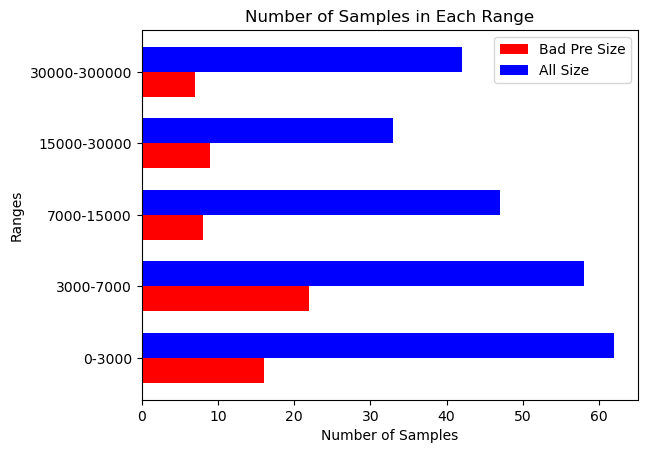

In [377]:
# 定义区间

# 计算每个区间的样本数
def count_in_ranges(data, ranges):
    counts = []
    for r in ranges:
        count = ((data >= r[0]) & (data < r[1])).sum()
        counts.append(count)
    return counts

bad_pre_counts = count_in_ranges(bad_pre_size_data, ranges)
all_size_counts = count_in_ranges(all_size_data, ranges)

# 创建条形图
y_positions = np.arange(len(ranges))
bar_width = 0.35

plt.barh(y_positions - bar_width/2, bad_pre_counts, bar_width, label='Bad Pre Size', color='red')
plt.barh(y_positions + bar_width/2, all_size_counts, bar_width, label='All Size', color='blue')

# 设置 y 轴的刻度标签
plt.yticks(y_positions, [f"{r[0]}-{r[1]}" for r in ranges])

plt.xlabel('Number of Samples')
plt.ylabel('Ranges')
plt.title('Number of Samples in Each Range')
plt.legend()

plt.show()

In [404]:
bad_pre_size.iloc[[23,25,38,45,61,11,29,35],]

,PID,Subject,Experiment,Scan,pHGP,dHGP,rHGP,HGP_Type,Series_description,acquisition_time,...,seriesdate_y,gender,age,model_name,patient_position,manufacturer,slice_thickness,convolution_kernel,prediction,tumor_size
76,771262,CRLM_030,CT_20378,3,0.0,80.000000,20.000000,0,ABD. 5/5,151518.0000,...,NaN,F,081Y,Brilliance 64,FFS,Philips,"""5.00""",B,NaN,1926
81,483623,CRLM_015,CT_20985,2,0.0,80.000000,20.000000,0,IV 60 sec Portaal,105532.1500,...,20110909.0,M,064Y,Aquilion ONE,FFS,TOSHIBA,"""5.0""",FC02,NaN,3326
146,9036978,CRLM_306,CT_27925,13,15.0,81.666667,3.333333,0,D70 Onco ThAb 1.0 Bl57 3,133244.2280,...,20180109.0,F,058Y,SOMATOM Edge Plus,HFS,SIEMENS,"""1""","['Bl57f', '3']",NaN,340560
179,9032247,CRLM_305,CT_32505,3-CT1,0.0,98.333333,1.666667,0,Abdomen 2.0 B31f,164344.2707,...,20100116.0,M,055Y,Sensation 10,FFS,SIEMENS,"""2""",B31s,NaN,14080
231,8325505,CRLM_287,CT_77275,1,0.0,92.500000,7.500000,0,NaN,145733.0000,...,NaN,M,080Y,Mx8000 IDT 16,FFS,Philips,"""2.0""",B,NaN,33618
31,5978471,CRLM_199,CT_13416,6,0.0,85.000000,15.000000,0,ONCO ThAbd 1.5 B70f,114438.3126,...,20151119.0,M,045Y,Sensation 64,HFS,SIEMENS,"""1.5""",B70f,NaN,6360
101,9087307,CRLM_308,CT_22958,7,20.0,77.500000,2.500000,0,"3F thx,abd port 2.0 B31f",102638.9854,...,20070628.0,M,079Y,Sensation 16,HFS,SIEMENS,"""2""",B31f,NaN,1148626
131,2995387,CRLM_106,CT_26568,3,0.0,76.666667,23.333333,0,ABD AX 4MM,155645.0000,...,NaN,M,054Y,Brilliance 40,HFS,Philips,"""4.00""",B,NaN,28796


In [413]:
from scipy.stats import mannwhitneyu
mannwhitneyu(bad_pre_size.tumor_size.values,all_size.tumor_size.values)
# delete bad pre size from all size
all_size_no_bad = all_size[~all_size['Experiment'].isin(prediction_correct_2folds)]

In [420]:
bad_pre_size_dhgp = bad_pre_size[bad_pre_size['dHGP'] == 100]
bad_pre_size_non_dhgp = bad_pre_size[bad_pre_size['dHGP'] != 100]
all_size_dhgp = all_size[all_size['dHGP'] == 100]
all_size_non_dhgp = all_size[all_size['dHGP'] != 100]

In [424]:
mannwhitneyu(bad_pre_size_non_dhgp.tumor_size.values,all_size_non_dhgp.tumor_size.values)

mannwhitneyu(bad_pre_size_non_dhgp.dHGP.values,all_size_non_dhgp.dHGP.values)

MannwhitneyuResult(statistic=4800.5, pvalue=0.3841260517382219)

In [416]:
mannwhitneyu(bad_pre_size.tumor_size.values,all_size_no_bad.tumor_size.values)

mannwhitneyu(bad_pre_size.dHGP.values,all_size_no_bad.dHGP.values)


MannwhitneyuResult(statistic=6989.5, pvalue=0.0302651908628372)

In [398]:
bad_pre_size.dHGP.values

array([ 30.        ,   5.        , 100.        ,  20.        ,
        25.5       ,  20.        ,  76.66666667, 100.        ,
       100.        ,   1.25      ,  31.66666667,  85.        ,
        56.66666667,  17.5       , 100.        ,   5.        ,
         0.        ,  12.5       ,   0.        , 100.        ,
        26.66666667,  25.        ,   0.        ,  80.        ,
       100.        ,  80.        ,   2.5       , 100.        ,
       100.        ,  77.5       ,  70.        , 100.        ,
       100.        ,  56.66666667,   0.        ,  76.66666667,
       100.        ,   0.        ,  81.66666667,  50.        ,
         0.        ,  55.        ,  90.        ,  18.33333333,
       100.        ,  98.33333333,  49.375     ,   5.        ,
        80.        , 100.        , 100.        ,  20.        ,
       100.        ,  65.        ,  35.        , 100.        ,
       100.        ,  30.        ,  33.33333333,   0.625     ,
       100.        ,  92.5       ,  65.        , 100.  

In [369]:
np.quantile(bad_pre_size.tumor_size,0.75)

17076.5

Text(0, 0.5, 'tumor size')

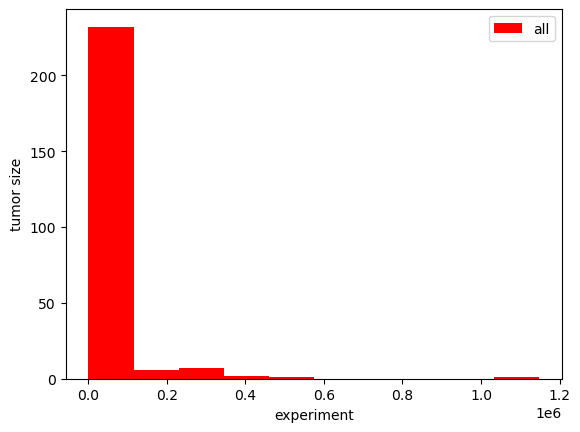

In [307]:
#plt.hist(bad_pre_size,label='bad prediction')
plt.hist(all_size,label='all',color='red')
plt.legend()
plt.xlabel('experiment')
plt.ylabel('tumor size')

In [330]:
#quantile of tumor size
np.quantile(data_info.tumor_size.values.tolist(),0.25)

3048.0

In [314]:
np.asarray(bad_pre_size)<= 3048

array([False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True, False, False,  True,  True, False,  True,
       False, False, False, False, False, False, False,  True, False,
        True, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True, False, False, False, False, False, False,
        True])

In [201]:
data_dHGP = data_info[data_info['HGP_Type'] == 1]
data_all_HGP = data_info['HGP_Type'].values.tolist()
data_dHGP_name = data_dHGP.Experiment.values.tolist()
#add suffix 0 to each name
data_dHGP_name = [i+'0' for i in data_dHGP_name]
data_all_HGP_name = [i +'0' for i in data_info.Experiment.values.tolist()]

In [202]:
import SimpleITK as sitk
import os
pre_fix = 'CILM_'
suffix = '.nii.gz'
data_dHGP_name = [pre_fix+i+suffix for i in data_dHGP_name]
data_all_HGP_name = [pre_fix+i+suffix for i in data_all_HGP_name]
data_folder = os.listdir('../../Data/Mixed_HGP/Mxied_HGP_mask/')
tumor_size = {i:None for i in data_all_HGP_name}
for img_file in data_all_HGP_name:

    img_path = os.path.join('../../Data/Mixed_HGP/Mxied_HGP_mask/',img_file)
    img = sitk.ReadImage(img_path)
    img = sitk.GetArrayFromImage(img)
    img[img==1] = 0
    tumor_size[img_file] = img.sum()


In [194]:

for img_file in data_all_HGP_name:

    img_path = os.path.join('../../Data/Mixed_HGP/Mxied_HGP_mask/',img_file)
    img = sitk.ReadImage(img_path)
    img = sitk.GetArrayFromImage(img)
    img[img==1] = 0
    tumor_size[img_file] = img.sum()


val_4_info = pd.read_csv('../../Data/Mixed_HGP/True_Label/val_cv_0.csv')
val_4_info = val_4_info[val_4_info['HGP_Type'] == 1]
val_4_data_name = val_4_info.Experiment.values.tolist()
val_4_data_name = [i+'0' for i in val_4_data_name]
val_4_data_name = [pre_fix+i+suffix for i in val_4_data_name]


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "../../Data/Mixed_HGP/Mxied_HGP_mask/CT_100330" does not exist.

In [204]:
data_info['tumor_size'] = tumor_size.values()

In [207]:
data_info.to_csv('../../Data/Mixed_HGP/True_Label/scans_used_all_info_with_tumor.csv',index=False)

In [206]:
tumor_size

{'CILM_CT_100330.nii.gz': 9814,
 'CILM_CT_100430.nii.gz': 2504,
 'CILM_CT_101040.nii.gz': 1850,
 'CILM_CT_102030.nii.gz': 260068,
 'CILM_CT_107020.nii.gz': 12020,
 'CILM_CT_107850.nii.gz': 163408,
 'CILM_CT_108710.nii.gz': 3048,
 'CILM_CT_109290.nii.gz': 18782,
 'CILM_CT_109300.nii.gz': 7674,
 'CILM_CT_109540.nii.gz': 376,
 'CILM_CT_109630.nii.gz': 5132,
 'CILM_CT_111110.nii.gz': 3914,
 'CILM_CT_111360.nii.gz': 56132,
 'CILM_CT_111550.nii.gz': 18924,
 'CILM_CT_114470.nii.gz': 23270,
 'CILM_CT_116550.nii.gz': 3150,
 'CILM_CT_116560.nii.gz': 13848,
 'CILM_CT_117840.nii.gz': 13708,
 'CILM_CT_119090.nii.gz': 680,
 'CILM_CT_119760.nii.gz': 13412,
 'CILM_CT_120170.nii.gz': 4812,
 'CILM_CT_121900.nii.gz': 746,
 'CILM_CT_122760.nii.gz': 3954,
 'CILM_CT_125750.nii.gz': 10754,
 'CILM_CT_127240.nii.gz': 354,
 'CILM_CT_129060.nii.gz': 678,
 'CILM_CT_129270.nii.gz': 6006,
 'CILM_CT_129570.nii.gz': 25078,
 'CILM_CT_131630.nii.gz': 20330,
 'CILM_CT_132360.nii.gz': 1176,
 'CILM_CT_133290.nii.gz': 8249

In [264]:
for i in val_4_data_name:
    print(tumor_size[i])

376
1176
2318
2424
28490
17746
65474
31960
2474
5020


In [95]:
import numpy as np
from sklearn.metrics import roc_auc_score,roc_curve
y_pred_1 = np.stack([y.detach().cpu().numpy() for y in y_pred],axis=0)[:,:,1].reshape(-1)
#Prob of samples more
y_true_1 = np.array(y_true).reshape(-1)
#with more thresholds

fpr,tpr,thresholds = roc_curve(y_true_1,y_pred_1,drop_intermediate=True)
roc_auc = roc_auc_score(y_true_1,y_pred_1)
#plot roc curve
plt.plot(fpr,tpr,label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

AttributeError: 'numpy.float32' object has no attribute 'detach'

In [111]:
fpr,tpr

(array([0.        , 0.        , 0.05128205, 0.05128205, 0.12820513,
        0.12820513, 0.30769231, 0.30769231, 0.35897436, 0.35897436,
        0.38461538, 0.38461538, 0.51282051, 0.51282051, 0.56410256,
        0.56410256, 0.61538462, 0.61538462, 0.8974359 , 0.8974359 ,
        1.        ]),
 array([0.        , 0.09090909, 0.09090909, 0.27272727, 0.27272727,
        0.36363636, 0.36363636, 0.45454545, 0.45454545, 0.54545455,
        0.54545455, 0.63636364, 0.63636364, 0.72727273, 0.72727273,
        0.81818182, 0.81818182, 0.90909091, 0.90909091, 1.        ,
        1.        ]))

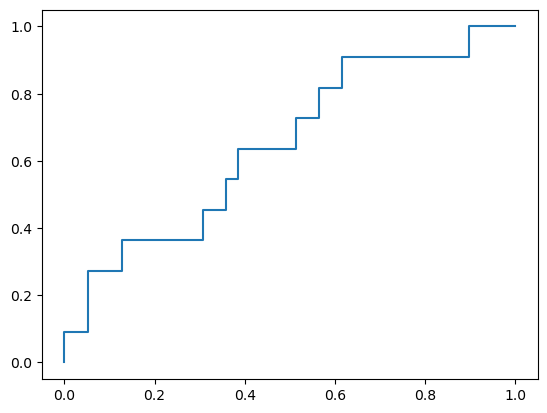

In [107]:
plt.plot(fpr,tpr)

array([0.        , 0.09090909, 0.09090909, 0.27272727, 0.27272727,
       0.36363636, 0.36363636, 0.45454545, 0.45454545, 0.54545455,
       0.54545455, 0.63636364, 0.63636364, 0.72727273, 0.72727273,
       0.81818182, 0.81818182, 0.90909091, 0.90909091, 1.        ,
       1.        ])

In [97]:
thresholds

array([       inf, 0.62786925, 0.60064906, 0.57187915, 0.53852826,
       0.5372427 , 0.49775353, 0.4928783 , 0.48763266, 0.4862657 ,
       0.4856193 , 0.48331326, 0.46506658, 0.46488842, 0.4563023 ,
       0.45571586, 0.45194674, 0.4519    , 0.41225085, 0.40647322,
       0.3738449 ], dtype=float32)

In [97]:

train_loss = train_loss['loss'].values.tolist()
val_loss = val_loss['loss'].values.tolist()

train_loss = [round(float(i),3) for i in train_loss]
val_loss = [round(float(i),3) for i in val_loss]

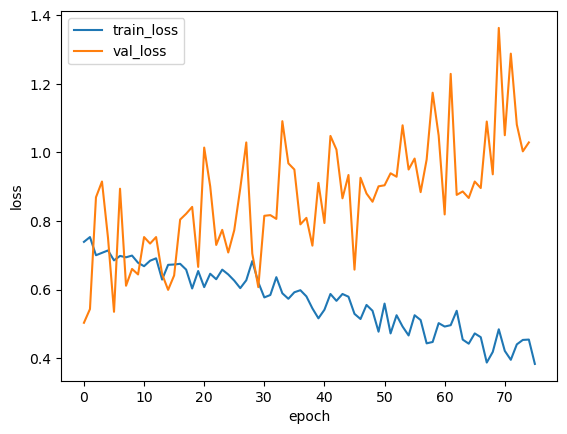

In [98]:
epoch_axis = range(100)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')

#plt.xticks(epoch_axis)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [88]:
train_rates = pd.read_csv('../../Output/SwingTransformer/Cluster/Test_02/01train_Four_rate.csv')

train_acc = train_rates.iloc[1::6]['accuracy']

val_rates = pd.read_csv('../../Output/SwingTransformer/Cluster/Test_02/01vali_four rates.csv')

val_acc = val_rates.iloc[1::6]['accuracy']

In [73]:
train_rates.iloc[1::6]['precision']

1      0.3157894736842105
7                  0.4375
13     0.5526315789473685
19                    0.5
25     0.4492753623188406
              ...        
691    0.7108433734939759
697    0.8188976377952756
703    0.7666666666666667
709    0.7685185185185185
715    0.7619047619047619
Name: precision, Length: 120, dtype: object

In [89]:
train_precision = train_rates.iloc[1::6]['precision'].values.tolist()
train_recall = train_rates.iloc[1::6]['recall'].values.tolist()

train_precision = [round(float(i),3) for i in train_precision]
train_recall = [round(float(i),3) for i in train_recall]


val_precision = val_rates.iloc[1::6]['precision'].values.tolist()
val_recall = val_rates.iloc[1::6]['recall'].values.tolist()

val_precision = [round(float(i),3) for i in val_precision]
val_recall = [round(float(i),3) for i in val_recall]


In [85]:
train_recall

[0.22,
 0.368,
 0.612,
 0.49,
 0.344,
 0.61,
 0.527,
 0.688,
 0.718,
 0.653,
 0.535,
 0.651,
 0.615,
 0.713,
 0.505,
 0.566,
 0.541,
 0.92,
 0.57,
 0.747,
 0.337,
 0.494,
 0.663,
 0.726,
 0.588,
 0.819,
 0.745,
 0.608,
 0.739,
 0.689,
 0.564,
 0.614,
 0.573,
 0.789,
 0.596,
 0.574,
 0.698,
 0.691,
 0.596,
 0.667,
 0.649,
 0.657,
 0.553,
 0.74,
 0.774,
 0.644,
 0.554,
 0.506,
 0.769,
 0.629,
 0.638,
 0.739,
 0.66,
 0.75,
 0.804,
 0.673,
 0.602,
 0.578,
 0.564,
 0.702,
 0.762,
 0.726,
 0.729,
 0.663,
 0.693,
 0.762,
 0.698,
 0.667,
 0.673,
 0.724,
 0.75,
 0.802,
 0.591,
 0.798,
 0.765,
 0.694,
 0.8,
 0.677,
 0.752,
 0.75,
 0.755,
 0.781,
 0.707,
 0.78,
 0.833,
 0.765,
 0.769,
 0.778,
 0.779,
 0.74,
 0.765,
 0.765,
 0.824,
 0.813,
 0.753,
 0.818,
 0.89,
 0.806,
 0.767,
 0.796,
 0.819,
 0.735,
 0.733,
 0.827,
 0.707,
 0.776,
 0.823,
 0.844,
 0.825,
 0.758,
 0.781,
 0.785,
 0.827,
 0.864,
 0.76,
 0.678,
 0.92,
 0.86,
 0.783,
 0.873]

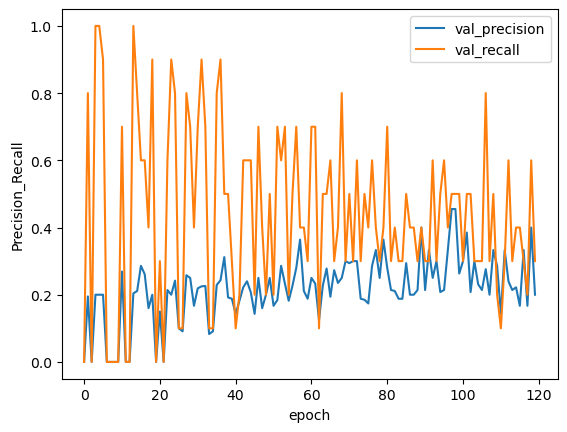

In [93]:
epoch_axis = range(120)
plt.plot(val_precision,label='val_precision')
plt.plot(val_recall,label='val_recall')

#plt.xticks(epoch_axis)
plt.xlabel('epoch')
plt.ylabel('Precision_Recall')
plt.legend()

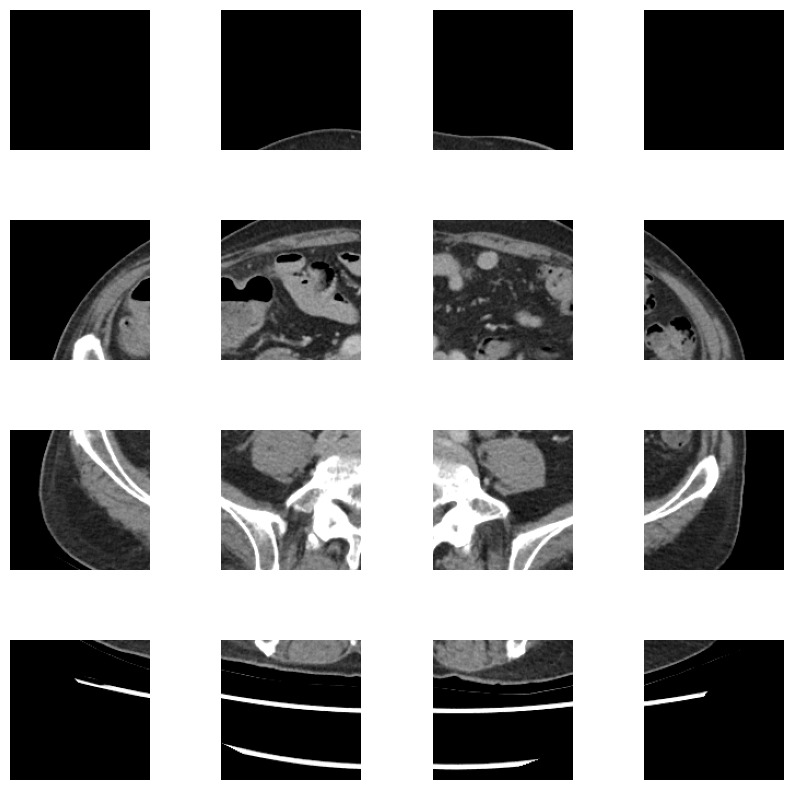

In [284]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_image_in_patches(image_path, patch_size=128, spacing=0.5):
    # 打开图像并转换为numpy数组
    img = Image.open(image_path)
    img_np = np.array(img)

    # 获取图像尺寸
    h, w = img_np.shape[:2]

    # 计算每个维度的切片数
    x_patches = w // patch_size
    y_patches = h // patch_size

    # 创建绘图
    fig, axs = plt.subplots(y_patches, x_patches, figsize=(10, 10))
    
    # 为了避免在边界上的图像信息丢失，我们可以稍微调整每个 patch 的位置
    for i in range(y_patches):
        for j in range(x_patches):
            # 计算每个 patch 的坐标
            x_start = j * patch_size
            y_start = i * patch_size
            x_end = min(x_start + patch_size, w)
            y_end = min(y_start + patch_size, h)

            # 提取 patch
            patch = img_np[y_start:y_end, x_start:x_end]

            # 绘制 patch
            axs[i, j].imshow(patch)
            axs[i, j].axis('off')  # 关闭坐标轴

    # 调整子图之间的间距
    plt.subplots_adjust(wspace=spacing, hspace=spacing)
    plt.savefig('../../Output/Thesis/Graph/model_arc.png')
    plt.show()

# 使用示例
image_path = '../../Data/CT_Phase/Full_Image_Liver_slice_07075_windowed_2D/Study_id_CT_101040_slice_22.png'
plot_image_in_patches(image_path)


In [12]:
import numpy as np
import scipy.stats as stats

def calculate_confidence_interval(scores, confidence_level=0.95):
    """
    计算给定分数的95%置信区间。
    
    参数:
    - scores: 包含多个folds验证结果的数组。
    - confidence_level: 置信水平，默认为0.95。
    
    返回:
    - mean: 分数的平均值。
    - ci_lower: 置信区间的下界。
    - ci_upper: 置信区间的上界。
    """
    # 计算均值和标准误差
    mean = np.mean(scores)
    se = stats.sem(scores)  # sem计算标准误差
    
    # 计算置信区间
    ci_range = stats.t.interval(confidence_level, len(scores)-1, loc=mean, scale=se)
    ci_lower, ci_upper = ci_range
    
    return mean, ci_lower, ci_upper

# 示例数据：5个folds的验证结果
scores = np.array([0.3157,0.1538,0.1538])
mean, ci_lower, ci_upper = calculate_confidence_interval(scores)

print(f"Mean: {mean:.3f}, 95% CI: ({ci_lower:.3f}, {ci_upper:.3f})")
#


Mean: 0.208, 95% CI: (-0.024, 0.440)


In [113]:
os.listdir(image_path)

['Study_id_CT_101040_slice_0.png',
 'Study_id_CT_101040_slice_1.png',
 'Study_id_CT_101040_slice_10.png',
 'Study_id_CT_101040_slice_11.png',
 'Study_id_CT_101040_slice_12.png',
 'Study_id_CT_101040_slice_13.png',
 'Study_id_CT_101040_slice_14.png',
 'Study_id_CT_101040_slice_15.png',
 'Study_id_CT_101040_slice_16.png',
 'Study_id_CT_101040_slice_17.png',
 'Study_id_CT_101040_slice_18.png',
 'Study_id_CT_101040_slice_19.png',
 'Study_id_CT_101040_slice_2.png',
 'Study_id_CT_101040_slice_20.png',
 'Study_id_CT_101040_slice_21.png',
 'Study_id_CT_101040_slice_22.png',
 'Study_id_CT_101040_slice_23.png',
 'Study_id_CT_101040_slice_24.png',
 'Study_id_CT_101040_slice_25.png',
 'Study_id_CT_101040_slice_26.png',
 'Study_id_CT_101040_slice_27.png',
 'Study_id_CT_101040_slice_28.png',
 'Study_id_CT_101040_slice_29.png',
 'Study_id_CT_101040_slice_3.png',
 'Study_id_CT_101040_slice_30.png',
 'Study_id_CT_101040_slice_31.png',
 'Study_id_CT_101040_slice_32.png',
 'Study_id_CT_101040_slice_33.pn